<a href="https://colab.research.google.com/github/PuChan-HCI/visualization/blob/main/CAMs/GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GradCAM**

In computer vision, interpretability is crucial for understanding and justifying the decisions made
by models. Pytorch-GradCAM library is a popular tool used for interpretability in computer vision
algorithms. The library offers several variations, including GradCAM, GradCAMPlusPlus, EigenCAM, ScoreCAM, GradCAMElementWise, and XGradCAM, each providing different insights into
the model’s decision-making process.
For this practical question, select a pre-trained backbone model such as ResNet and use the GradCAM library and its variations to interpret its results. The task involves:

# 1. Applying each of the mentioned methods

Import necessary libraries and load the pre-trained ResNet model

In [1]:
!pip install grad_cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.0 MB/s

In [2]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus , EigenCAM, ScoreCAM, GradCAMElementWise, XGradCAM
from pytorch_grad_cam.metrics.road import ROADCombined
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
from PIL import Image
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
import time

# load pretrained model
model = models.resnet50(pretrained=True)
model.eval()


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 2. Compare and rank each method based on time

Apply Grad-CAM methods to the sample images

In [5]:
# Showing the metrics on top of the CAM :
def visualize_score(visualization, score, name, times):
    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"score: {score:.5f}", (10,40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"time: {times:.5f}", (10, 60),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def benchmark(input_tensor,img, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    # Initialize Grad-CAM methods
    # Removed the 'use_cuda=True' argument from the initialization
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("EigenCAM",EigenCAM(model, target_layers)),
               ("ScoreCAM",ScoreCAM(model, target_layers)),
               ("GradCAMElementWise",GradCAMElementWise(model, target_layers)),
               ("XGradCAM",XGradCAM(model, target_layers))
               ]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    visualizations = []
    time_results = []
    for name, cam_method in methods:
        start_time = time.time()
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor, targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        end_time = time.time()
        time_results.append(end_time - start_time)
        attribution = attributions[0, :]
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        visualization = show_cam_on_image(img, attribution, use_rgb=True)
        visualization = visualize_score(visualization, scores[0], name,time_results[-1])
        visualizations.append(visualization)

    # Rank the methods based on time taken
    time_results = np.array(time_results)
    vis = np.array(visualizations)
    inds =list(time_results.argsort())
    visualizations = list(vis[inds])
    return Image.fromarray(np.hstack(visualizations))

 Load and preprocess the sample images

100%|██████████| 128/128 [00:07<00:00, 16.76it/s]


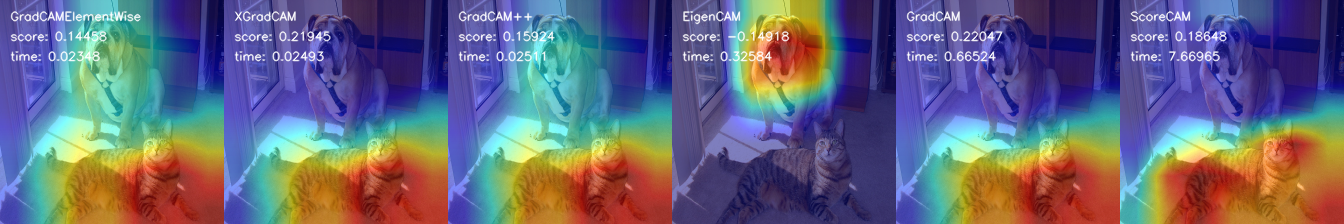

In [6]:
# load and preprocess cat and dog photo
cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
cat_and_dog = np.float32(cat_and_dog) / 255
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Apply Grad-CAM methods to the sample image
target_layers = [model.layer4]
model.cuda()
input_tensor = input_tensor.cuda()
np.random.seed(42)
category = 281 #cat category
benchmark(input_tensor,cat_and_dog, target_layers, eigen_smooth=False, aug_smooth=False,category = category)


In [ ]:
# load and preprocess bear photo
bear_url ="https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
bear = np.array(Image.open(requests.get(bear_url, stream=True).raw))
bear = cv2.resize(bear, (224, 224))
bear = np.float32(bear) / 255
input_tensor2 = preprocess_image(bear, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


# Apply Grad-CAM methods to the sample image bear
target_layers = [model.layer4]
model.cuda()
input_tensor2 = input_tensor2.cuda()
np.random.seed(42)
category = 295 #bear category
benchmark(input_tensor2,bear, target_layers, eigen_smooth=False, aug_smooth=False,category =category)

# 3. evaluation metric implementation

To explain how used metric work, i should say that here for each percentile we first we Remove the highest attention pixels first by the mean (for R,G,B separately) : Most Relevant First (MORF).
and after that Remove the least attention pixels first by the mean (for R,G,B separately) : Least Relevant First (LERF).
at last we compute desired score like this :

**(Least Relevant First - Most Relevant First) / 2**

Here, To have more robust metric we compute this metric for diffrent percentile and **average** the results.
this metric is called ROAD (Remove and Debias)

paper: https://arxiv.org/abs/2202.00449

# Conclusion

XGradCAM and GradCAM++ are found to provide a good trade-off between interpretability and reasonable runtime. Here, the ROAD metric which is described before is used as an evaluation metric.